Modelling crime risk associated with Green Spaces
---
A case study of New York City using NYPD Complaint Data and Machine Learning models

| Authors                        | Student ID   |
|--------------------------------|--------------|
| Kaninik Baradi                 | 5216664      |
| Lala Sayyida Millati Nadhira   | 5844266      |
| Rezzy Yolanda Wulandhari       | 4779487      |
| Kelvin Engee                   | 4664043      |
| Philippe Almeida Mirault       | 5898803      |
Group 4

For the course: Responsible Data Analytics, SEN 163B
April 2023

# Introduction
This notebook is a companion to the report on Modelling Crime Risks associated with Green spaces. It contains all the code required to download, pre-process and analyse the data. The notebook is divided into the following sections:
- Preparation
- Descriptive Analytics
    - Preliminary Analysis
- Diagnostic Analytics
    - Feature Analysis
    - Feature Engineering
    - Bias Analysis
- Predictive Analysis
    - Target Variable Analysis
    - Train-Test Split Strategy
    - Model Evaluation
    - Model Interpretation
- Prescriptive Analysis
    - Cross Validation
    - Ensemble Predictor
    - Model Deployment

# Preparation

Dependencies:

Data Sources:

### Environment Setup

In [147]:
!pip install aequitas

     ---------------------------------------- 2.2/2.2 MB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 45.8/45.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 456.4/456.4 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 161.9/161.9 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 97.3/97.3 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 83.0/83.0 kB 4.9 MB/s eta 0:00:00
  Preparing 

In [13]:
path_to_data = '..//data//' # path to the data folder

testing_mode = True # set to True to run the notebook in testing mode with reduced data imports


Import Dependencies

In [148]:
import pandas
import altair
import numpy
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap

In [15]:
# Initialise a seaborn theme for printing
# Set the context to "paper"
sns.set_context("paper")
# Set the style to "ticks"
sns.set_style("ticks")
# Set the font scale
sns.set(font_scale=1.5)
# Set the palette to a colorblind-friendly palette
sns.set_palette("colorblind")
# Set the figure size
plt.figure(figsize=(8, 6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

# Descriptive Analytics
This section contains the initial analysis of the selected data sets. It identifies the underlying relationships of the variables and if used to determine variables of interest for further analysis.

## Complaints Data

Read in the data from the NYPD Complaint Data set

In [16]:
# Create a function that selects every third number
def every_nth(n):
    return n % 10 == 0

if testing_mode:
    skipping = lambda i: i>0 and every_nth(i)
else:
    skipping = None

crime_data = pandas.read_csv("..\\NYPD_Complaint_Data_Historic.csv", skiprows=skipping)

FileNotFoundError: [Errno 2] No such file or directory: '..\\NYPD_Complaint_Data_Historic.csv'

In [66]:
crime_data = pandas.read_csv("NYPD_Complaint_Data_Historic.csv", skiprows=skipping)

C:\Users\Kelvi\AppData\Local\Temp\ipykernel_6828\3182987543.py:1: DtypeWarning: Columns (18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  crime_data = pandas.read_csv("NYPD_Complaint_Data_Historic.csv", skiprows=skipping)


In [67]:
def make_categorical(dataframe, column):
    # make the column of the dataframe categorical
    dataframe[column] = dataframe[column].astype('category')

# get a lst of all the columns in the dataframe that need to be categorical
#scrub for duplicate
crime_data.drop_duplicates(inplace=True)

columns = ['ADDR_PCT_CD', 'BORO_NM', 'CRM_ATPT_CPTD_CD', 'HADEVELOPT', 'HOUSING_PSA', 'JURISDICTION_CODE', 'JURIS_DESC', 'KY_CD', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PARKS_NM', 'PATROL_BORO', 'PD_CD', 'PD_DESC', 'STATION_NAME', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT', 'VIC_RACE', 'VIC_SEX']

    # make each column categorical
for column in columns:
    make_categorical(crime_data, column)

### Exploratory Data Analysis

### Data Cleaning

In [68]:
#scrub for irrelevant data (only use required columns)
crime_data = crime_data[['CMPLNT_FR_DT','CMPLNT_FR_TM','Longitude','Latitude','VIC_SEX','VIC_RACE','VIC_AGE_GROUP']]

# All missing data from the selected columns is dropped as it will negatively impact the analysis, and the data is missing completely at random
crime_data = crime_data.dropna(axis=0)

#### Transforming Complaint Date
The date recorded for the estimated start time of the complaint `CMPLNT_FR_DT` is transformed to the year and the, day of the week. The day of the week is used to determine if the complaints are more likely to occur on a weekend or a weekday. The year is used to determine if the crime is more likely to occur in a certain year.

In [69]:
crime_data['year'] = crime_data['CMPLNT_FR_DT'].str.split('/',expand=True)[2].astype(int)

In [70]:
crime_data = crime_data.loc[crime_data['year'] >= 2006]

In [71]:
crime_data['CMPLNT_FR_DT'] = pandas.to_datetime(crime_data['CMPLNT_FR_DT'], format='%m/%d/%Y')
crime_data['day_of_week'] = crime_data['CMPLNT_FR_DT'].dt.dayofweek

In [72]:
crime_data = crime_data.drop('CMPLNT_FR_DT', axis=1)

#### Transforming Complaint time
The time recorded for the estimated start time of the complaint `CMPLNT_FR_TM` is transformed to the hour. The hour is used to determine if the complaints are more likely to occur at a certain time of the day. The second and minute are dropped as they are not relevant to the analysis.

In [73]:
crime_data['hour'] = crime_data['CMPLNT_FR_TM'].str.split(':',expand=True)[0].astype(int)

In [74]:
crime_data = crime_data.drop('CMPLNT_FR_TM', axis=1)

#### Removing non-human victims
The data set contains a number of complaints where the victim is either not an individual that is a legal person, of the abstract concept of the people. These complaints are removed from the data set as they are not relevant to the analysis.

In [75]:
sexes = ['M', 'F', 'U']

crime_data = crime_data.loc[crime_data['VIC_SEX'].isin(sexes)]
# Re calculate the categories for the Sex column
crime_data['VIC_SEX'] = crime_data['VIC_SEX'].cat.remove_unused_categories()

del sexes
crime_data.head(5)

,Longitude,Latitude,VIC_SEX,VIC_RACE,VIC_AGE_GROUP,year,day_of_week,hour
0,-73.941064,40.810877,F,WHITE,25-44,2018,3,20
3,-73.994706,40.759310,F,WHITE HISPANIC,18-24,2018,5,21
8,-73.913278,40.635516,M,BLACK,<18,2018,1,14
9,-73.952037,40.803905,M,BLACK,25-44,2018,2,18
10,-73.894994,40.827049,F,BLACK,45-64,2018,6,17


#### Remove Unknown Race
Race is used in the model to check model fairness and performance. Race is Unknown in some cases, and these cases are removed from the data set.

In [76]:
# Keep everything except for UNKNOWN
races = ['WHITE', 'WHITE HISPANIC', 'BLACK','ASIAN / PACIFIC ISLANDER', 'BLACK HISPANIC','AMERICAN INDIAN/ALASKAN NATIVE', 'OTHER']

crime_data = crime_data.loc[crime_data['VIC_RACE'].isin(races)]
# Re calculate the categories for the Sex column
crime_data['VIC_RACE'] = crime_data['VIC_RACE'].cat.remove_unused_categories()

del races

In [77]:
crime_data.head(5)

,Longitude,Latitude,VIC_SEX,VIC_RACE,VIC_AGE_GROUP,year,day_of_week,hour
0,-73.941064,40.810877,F,WHITE,25-44,2018,3,20
3,-73.994706,40.759310,F,WHITE HISPANIC,18-24,2018,5,21
8,-73.913278,40.635516,M,BLACK,<18,2018,1,14
9,-73.952037,40.803905,M,BLACK,25-44,2018,2,18
10,-73.894994,40.827049,F,BLACK,45-64,2018,6,17


#### Remove Unknown or corrupted age
Most age values are expressed as a range. In cases where the age value is not correctly recorded, the age is removed from the data set. This is done as the age is used to determine if the crime is more likely to occur to a certain age group.

In [78]:
crime_data['VIC_AGE_GROUP'] = numpy.where(crime_data['VIC_AGE_GROUP'].str.len()==4, None, crime_data['VIC_AGE_GROUP'])
crime_data['VIC_AGE_GROUP'] = numpy.where(crime_data['VIC_AGE_GROUP'].str.startswith("-"), None, crime_data['VIC_AGE_GROUP'])
crime_data['VIC_AGE_GROUP'] = numpy.where(crime_data['VIC_AGE_GROUP'].str.contains("<"), crime_data['VIC_AGE_GROUP'] + ' ', crime_data['VIC_AGE_GROUP'])
crime_data['VIC_AGE_GROUP'] = numpy.where(crime_data['VIC_AGE_GROUP'].str.endswith("+"), crime_data['VIC_AGE_GROUP'] + ' ', crime_data['VIC_AGE_GROUP'])
crime_data['VIC_AGE_GROUP'] = numpy.where(crime_data['VIC_AGE_GROUP'].str.contains("UNKNOWN"), None, crime_data['VIC_AGE_GROUP'])
crime_data['VIC_AGE_GROUP'] = numpy.where(crime_data['VIC_AGE_GROUP'].str.len()==3, None, crime_data['VIC_AGE_GROUP'])

In [79]:
#delete None
crime_data = crime_data.dropna(subset=['VIC_AGE_GROUP'])

In [80]:
crime_data['VIC_AGE_GROUP'].unique()

array(['25-44', '18-24', '<18 ', '45-64', '65+ '], dtype=object)

#### One hot encoding
To indepedently evaluate the risks assocaited with sub-groups of the population, the categorical variables are one-hot encoded. Each group identifier is one-hot encoded, and these are later summed to evaluate the risk associated with each group.

In [81]:
one_hot_encoded = pandas.get_dummies(crime_data[['VIC_SEX','VIC_RACE','VIC_AGE_GROUP']])
one_hot_encoded

,VIC_SEX_F,VIC_SEX_M,VIC_SEX_U,VIC_RACE_AMERICAN INDIAN/ALASKAN NATIVE,VIC_RACE_ASIAN / PACIFIC ISLANDER,VIC_RACE_BLACK,VIC_RACE_BLACK HISPANIC,VIC_RACE_OTHER,VIC_RACE_WHITE,VIC_RACE_WHITE HISPANIC,VIC_AGE_GROUP_18-24,VIC_AGE_GROUP_25-44,VIC_AGE_GROUP_45-64,VIC_AGE_GROUP_65+,VIC_AGE_GROUP_<18
0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
8,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
9,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
10,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7042944,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
7042946,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
7042947,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
7042948,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0


In [82]:
# concatenate the one-hot encoded columns with the original dataframe
crime_data = pandas.concat([crime_data, one_hot_encoded], axis=1)
del one_hot_encoded

In [83]:
# drop the VIC_SEX, VIC_Race, and VIC_AGE_GROUP columns
crime_data = crime_data.drop('VIC_SEX', axis=1)
crime_data = crime_data.drop('VIC_RACE', axis=1)
crime_data = crime_data.drop('VIC_AGE_GROUP', axis=1)

# Feature Creation

### Transform the Latitude and Longitude
The probability of a complaint originating at any individaul arbitrarily specific point will always be close to zero. To enable a meaningful prediction, a coarse grid of related points needs to be developed. The following code defines a predictive grid which can be used to predict the probability of a crime occurring within any block of the city.

First a base grid is defined using the minimum and maximum bounds of the NYPD jurisdiction. The grid is defined as a 100 x 100 grid, and the coordinates are rounded to 5 decimal places.

In [84]:
# Create a grid of points across the precincts to use as the center of the crime clusters
# The size of the grid is n x n, where n is the number of points in each direction
from shapely.geometry import Point, Polygon
from rtree import index

precint_footprint = gpd.read_file('Police Precincts.geojson')

# get the bounds of the precincts
min_x, min_y, max_x, max_y = precint_footprint.total_bounds

idx = index.Index()
for i, row in precint_footprint.iterrows():
    idx.insert(i, row.geometry.bounds)

grid_size = 100  # You can adjust this value
x_points = np.linspace(min_x, max_x, grid_size)
y_points = np.linspace(min_y, max_y, grid_size)

# Round the points to 4 decimal places
x_points = np.around(x_points, 5)
y_points = np.around(y_points, 5)

grid = [Point(x, y) for x in x_points for y in y_points]

The grid is then filtered using the polygon of the NYPD jurisdiction. This is done to remove points that are outside the jurisdiction.

In [85]:

# drop the points that are not within the precincts
def is_point_inside_precincts(point, precincts_gdf, idx):
    for i in idx.intersection(point.bounds):
        if point.within(precincts_gdf.iloc[i].geometry):
            return True
    return False

filtered_grid = [point for point in grid if is_point_inside_precincts(point, precint_footprint, idx)]

# create a dataframe of the filtered grid
filtered_grid_df = pandas.DataFrame([(point.x, point.y) for point in filtered_grid], columns=['Longitude', 'Latitude'])
#
del grid
del filtered_grid

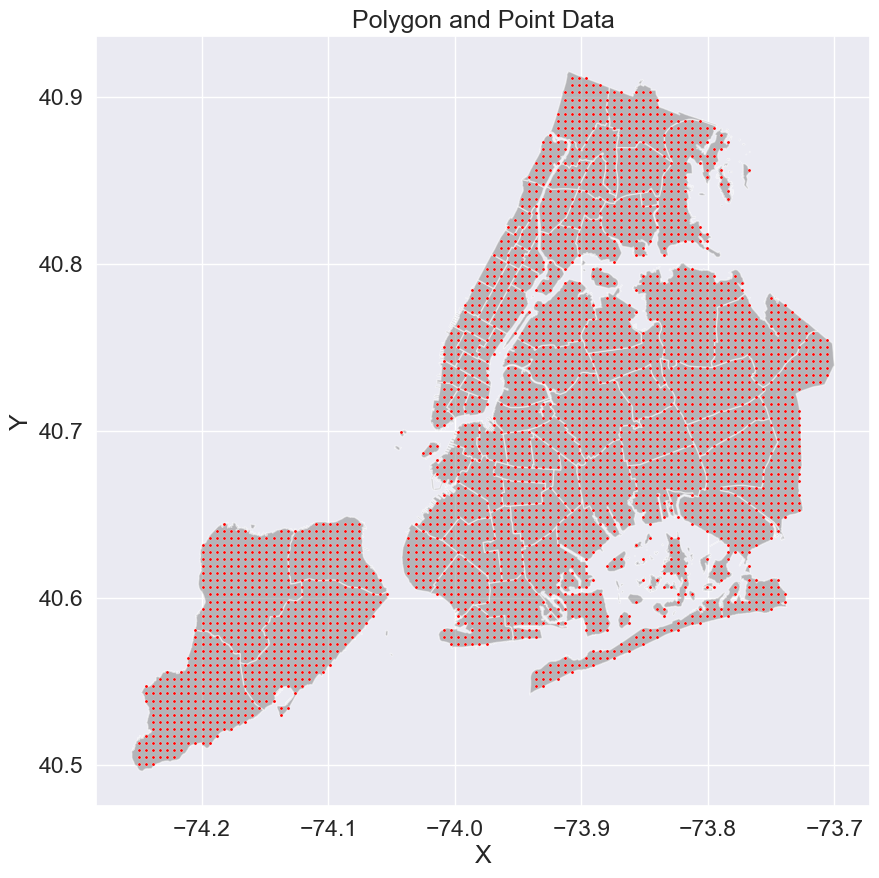

In [86]:

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygon using geopandas.plot()
precint_footprint.plot(ax=ax, facecolor="gray", alpha=0.5)

# Plot the points using seaborn.scatterplot()
sns.scatterplot(x="Longitude", y="Latitude", data=filtered_grid_df, color="red", s=5, ax=ax)

# Set the title and axis labels
ax.set_title("Polygon and Point Data")
ax.set_xlabel("X")
ax.set_ylabel("Y")

# Display the plot
plt.show()

del fig, ax # remove the figure and axis object to free up memory

All locations, of both crimes and trees will be transformed to a grid point. The following code uses a KD Tree to find the closest grid point to each crime. The grid point is then used as the location of the crime.

In [87]:
from scipy.spatial import cKDTree

# create a KD Tree with the Longitude and Latitude columns of filtered_grid_df
kd_tree = cKDTree(filtered_grid_df[['Longitude', 'Latitude']])

In [88]:
# query the KD Tree with the Longitude and Latitude columns of crime_data
distances, indices = kd_tree.query(crime_data[['Longitude', 'Latitude']])

# use the indices to get the corresponding Longitude and Latitude values from filtered_grid_df
crime_data['Longitude'] = filtered_grid_df.loc[indices, 'Longitude'].values
crime_data['Latitude'] = filtered_grid_df.loc[indices, 'Latitude'].values

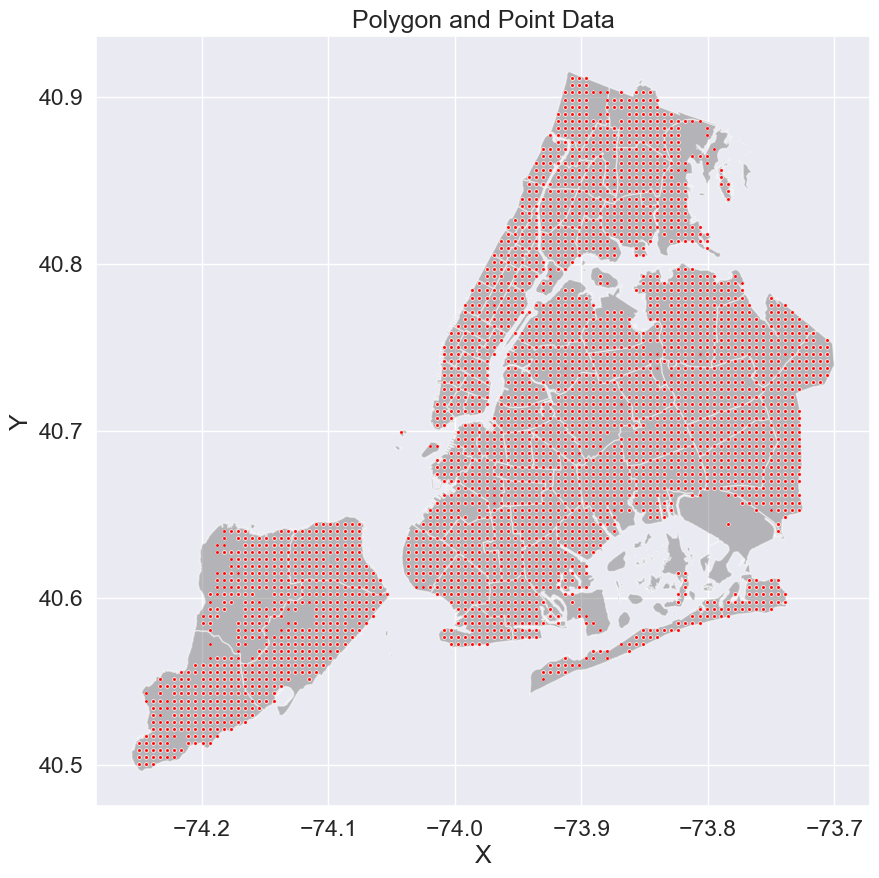

In [89]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygon using geopandas.plot()
precint_footprint.plot(ax=ax, facecolor="gray", alpha=0.5)

# Plot the points using seaborn.scatterplot()
sns.scatterplot(x="Longitude", y="Latitude", data=crime_data, color="red", s=5, ax=ax)

# Set the title and axis labels
ax.set_title("Polygon and Point Data")
ax.set_xlabel("X")
ax.set_ylabel("Y")

# Display the plot
plt.show()

del fig, ax # remove the figure and axis object to free up memory

In [90]:
crime_data = crime_data.loc[crime_data['Longitude'] > -74.5]

In [91]:
crime_data = crime_data.loc[crime_data['Latitude'] < 42.5]

In [92]:
crime_data

,Longitude,Latitude,year,day_of_week,hour,VIC_SEX_F,VIC_SEX_M,VIC_SEX_U,VIC_RACE_AMERICAN INDIAN/ALASKAN NATIVE,VIC_RACE_ASIAN / PACIFIC ISLANDER,VIC_RACE_BLACK,VIC_RACE_BLACK HISPANIC,VIC_RACE_OTHER,VIC_RACE_WHITE,VIC_RACE_WHITE HISPANIC,VIC_AGE_GROUP_18-24,VIC_AGE_GROUP_25-44,VIC_AGE_GROUP_45-64,VIC_AGE_GROUP_65+,VIC_AGE_GROUP_<18
0,-73.94132,40.80962,2018,3,20,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,-73.99744,40.75879,2018,5,21,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
8,-73.91326,40.63593,2018,1,14,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
9,-73.95255,40.80539,2018,2,18,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
10,-73.89643,40.82657,2018,6,17,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7042944,-73.90765,40.85622,2018,1,15,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
7042946,-74.10407,40.57662,2018,4,14,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
7042947,-73.86276,40.74184,2018,0,2,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
7042948,-74.08723,40.59357,2018,5,10,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0


### Group the Crime data
Sum the number of complaints for each unique point, hour of the day, day of the week, and year, over the various attributes of the victim of the crime.

In [93]:
crime_counts = (
    crime_data.groupby(['Longitude', 'Latitude', 'year', 'day_of_week', 'hour'])
    .sum()
)
crime_counts.reset_index(inplace=True)
del crime_data

## Street Trees Data
Data from the 2015 street tree census is used to estimate the impact of hte number of trees on the number of crimes. The data is available from the [NYC Open Data Portal](). The 'health' attribute of the trees is used to evaluate if the level of up-keep of the trees has any predictive power.

In [94]:
if testing_mode:
    rows = 20000
else:
    rows = None
trees = gpd.read_file('2015 Street Tree Census - Tree Data.geojson', rows=rows)

In [95]:
# drop the columns that we don't need
trees = trees[['health', 'longitude', 'latitude']]

In [96]:
# query the KD Tree with the Longitude and Latitude columns of crime_data
distances, indices = kd_tree.query(trees[['longitude', 'latitude']])

# use the indices to get the corresponding Longitude and Latitude values from filtered_grid_df
trees['Longitude'] = filtered_grid_df.loc[indices, 'Longitude'].values
trees['Latitude'] = filtered_grid_df.loc[indices, 'Latitude'].values

tree_counts = (
    trees.groupby(['Longitude', 'Latitude','health'])
    .size()
    .reset_index(name='tree_count')
)

In [97]:
tree_counts.head()

tree_counts_pivoted = pandas.pivot_table(tree_counts, values='tree_count', index=['Longitude', 'Latitude'], columns=['health'], fill_value=0)
tree_counts_pivoted = tree_counts_pivoted.reset_index().rename(columns={'Good': 'good_tree_count', 'Fair': 'fair_tree_count', 'Poor': 'poor_tree_count'})

# Remove index name
tree_counts_pivoted.index.name = None

## Engineer zero Values
Since the data set only contains reported complaints, it is necessary to infer and engineer examples of times and places from which complaints do not originate. To do this, a default matrix of zeros is created, and then the actual data is merged into the matrix.

The matrix covers all points and all permutations of times at which the crime could have occurred. The times are the hours of the day, the days of the week, and the years in the data set. The points are the grid points that were created earlier.

In [98]:
import itertools

def point_hour_day_combinations(points, hours, days_of_week, years):
    for point, hour, day, year in itertools.product(points, hours, days_of_week, years):
        yield point.x, point.y, hour, day, year

# Convert filtered grid points to a list of Point objects
points = [Point(lon, lat) for lon, lat in filtered_grid_df[['Longitude', 'Latitude']].values]

# Define hours and days_of_week
hours = range(24)
days_of_week = range(7)
years = range(2006, 2021)

In [99]:
all_combinations = np.array(list(point_hour_day_combinations(points, hours, days_of_week, years)))

### Reduce points for testing

In [100]:
if testing_mode:
    #REDUCE POINTS FOR TESTING
    # use numpy to drop all points that are left of the longitude of the mid point of the grid
    all_combinations = all_combinations[all_combinations[:, 0] > filtered_grid_df['Longitude'].median()]
    # use numpy to drop all points that are above the latitude of the mid point of the grid
    all_combinations = all_combinations[all_combinations[:, 1] < filtered_grid_df['Latitude'].median()]

In [101]:
crime_counts.set_index(['Longitude', 'Latitude', 'hour', 'day_of_week', 'year'], inplace=True)

In [102]:
matched_data = crime_counts.reindex(
    pandas.MultiIndex.from_arrays(all_combinations.T, names=crime_counts.index.names),
    fill_value=0
)
matched_data.reset_index(inplace=True)

matched_data = matched_data.merge(tree_counts_pivoted, on=['Longitude', 'Latitude'], how='left').fillna(0)

In [103]:
matched_data

,Longitude,Latitude,hour,day_of_week,year,VIC_SEX_F,VIC_SEX_M,VIC_SEX_U,VIC_RACE_AMERICAN INDIAN/ALASKAN NATIVE,VIC_RACE_ASIAN / PACIFIC ISLANDER,...,VIC_RACE_WHITE,VIC_RACE_WHITE HISPANIC,VIC_AGE_GROUP_18-24,VIC_AGE_GROUP_25-44,VIC_AGE_GROUP_45-64,VIC_AGE_GROUP_65+,VIC_AGE_GROUP_<18,fair_tree_count,good_tree_count,poor_tree_count
0,-73.90204,40.55968,0.0,0.0,2006.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0
1,-73.90204,40.55968,0.0,0.0,2007.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0
2,-73.90204,40.55968,0.0,0.0,2008.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0
3,-73.90204,40.55968,0.0,0.0,2009.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0
4,-73.90204,40.55968,0.0,0.0,2010.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282675,-73.72807,40.68253,23.0,6.0,2016.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
1282676,-73.72807,40.68253,23.0,6.0,2017.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
1282677,-73.72807,40.68253,23.0,6.0,2018.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
1282678,-73.72807,40.68253,23.0,6.0,2019.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0.0,0.0,0.0


In [104]:
# define risk count as the sum of all columns that start with 'VIC'
matched_data['crime_count'] = matched_data.filter(regex='VIC').sum(axis=1)

In [105]:
matched_data

,Longitude,Latitude,hour,day_of_week,year,VIC_SEX_F,VIC_SEX_M,VIC_SEX_U,VIC_RACE_AMERICAN INDIAN/ALASKAN NATIVE,VIC_RACE_ASIAN / PACIFIC ISLANDER,...,VIC_RACE_WHITE HISPANIC,VIC_AGE_GROUP_18-24,VIC_AGE_GROUP_25-44,VIC_AGE_GROUP_45-64,VIC_AGE_GROUP_65+,VIC_AGE_GROUP_<18,fair_tree_count,good_tree_count,poor_tree_count,crime_count
0,-73.90204,40.55968,0.0,0.0,2006.0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,1.0,0
1,-73.90204,40.55968,0.0,0.0,2007.0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,1.0,0
2,-73.90204,40.55968,0.0,0.0,2008.0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,1.0,0
3,-73.90204,40.55968,0.0,0.0,2009.0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,1.0,0
4,-73.90204,40.55968,0.0,0.0,2010.0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282675,-73.72807,40.68253,23.0,6.0,2016.0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0
1282676,-73.72807,40.68253,23.0,6.0,2017.0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0
1282677,-73.72807,40.68253,23.0,6.0,2018.0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0
1282678,-73.72807,40.68253,23.0,6.0,2019.0,0,1,0,0,0,...,0,0,1,0,0,0,0.0,0.0,0.0,3


In [106]:
# Create columns in matched_data called Risk_level
# if the sum of the crime counts is 0 then risk level is 0, if it is greater than 0 and less than 4 then risk level is 1, if it is greater than 3 then risk level is 2 and if it is greater than 6 then risk level is 3
def risk_level(crime_count):
    if crime_count == 0:
        return 0
    elif 0 < crime_count < 4:
        return 1
    elif 3 < crime_count < 7:
        return 2
    else:
        return 3

matched_data['Risk_level'] = matched_data['crime_count'].apply(risk_level)

In [107]:
# export matched_data to a parquet file
matched_data.to_parquet('matched_data.parquet')

# LAB 4

## Proxies

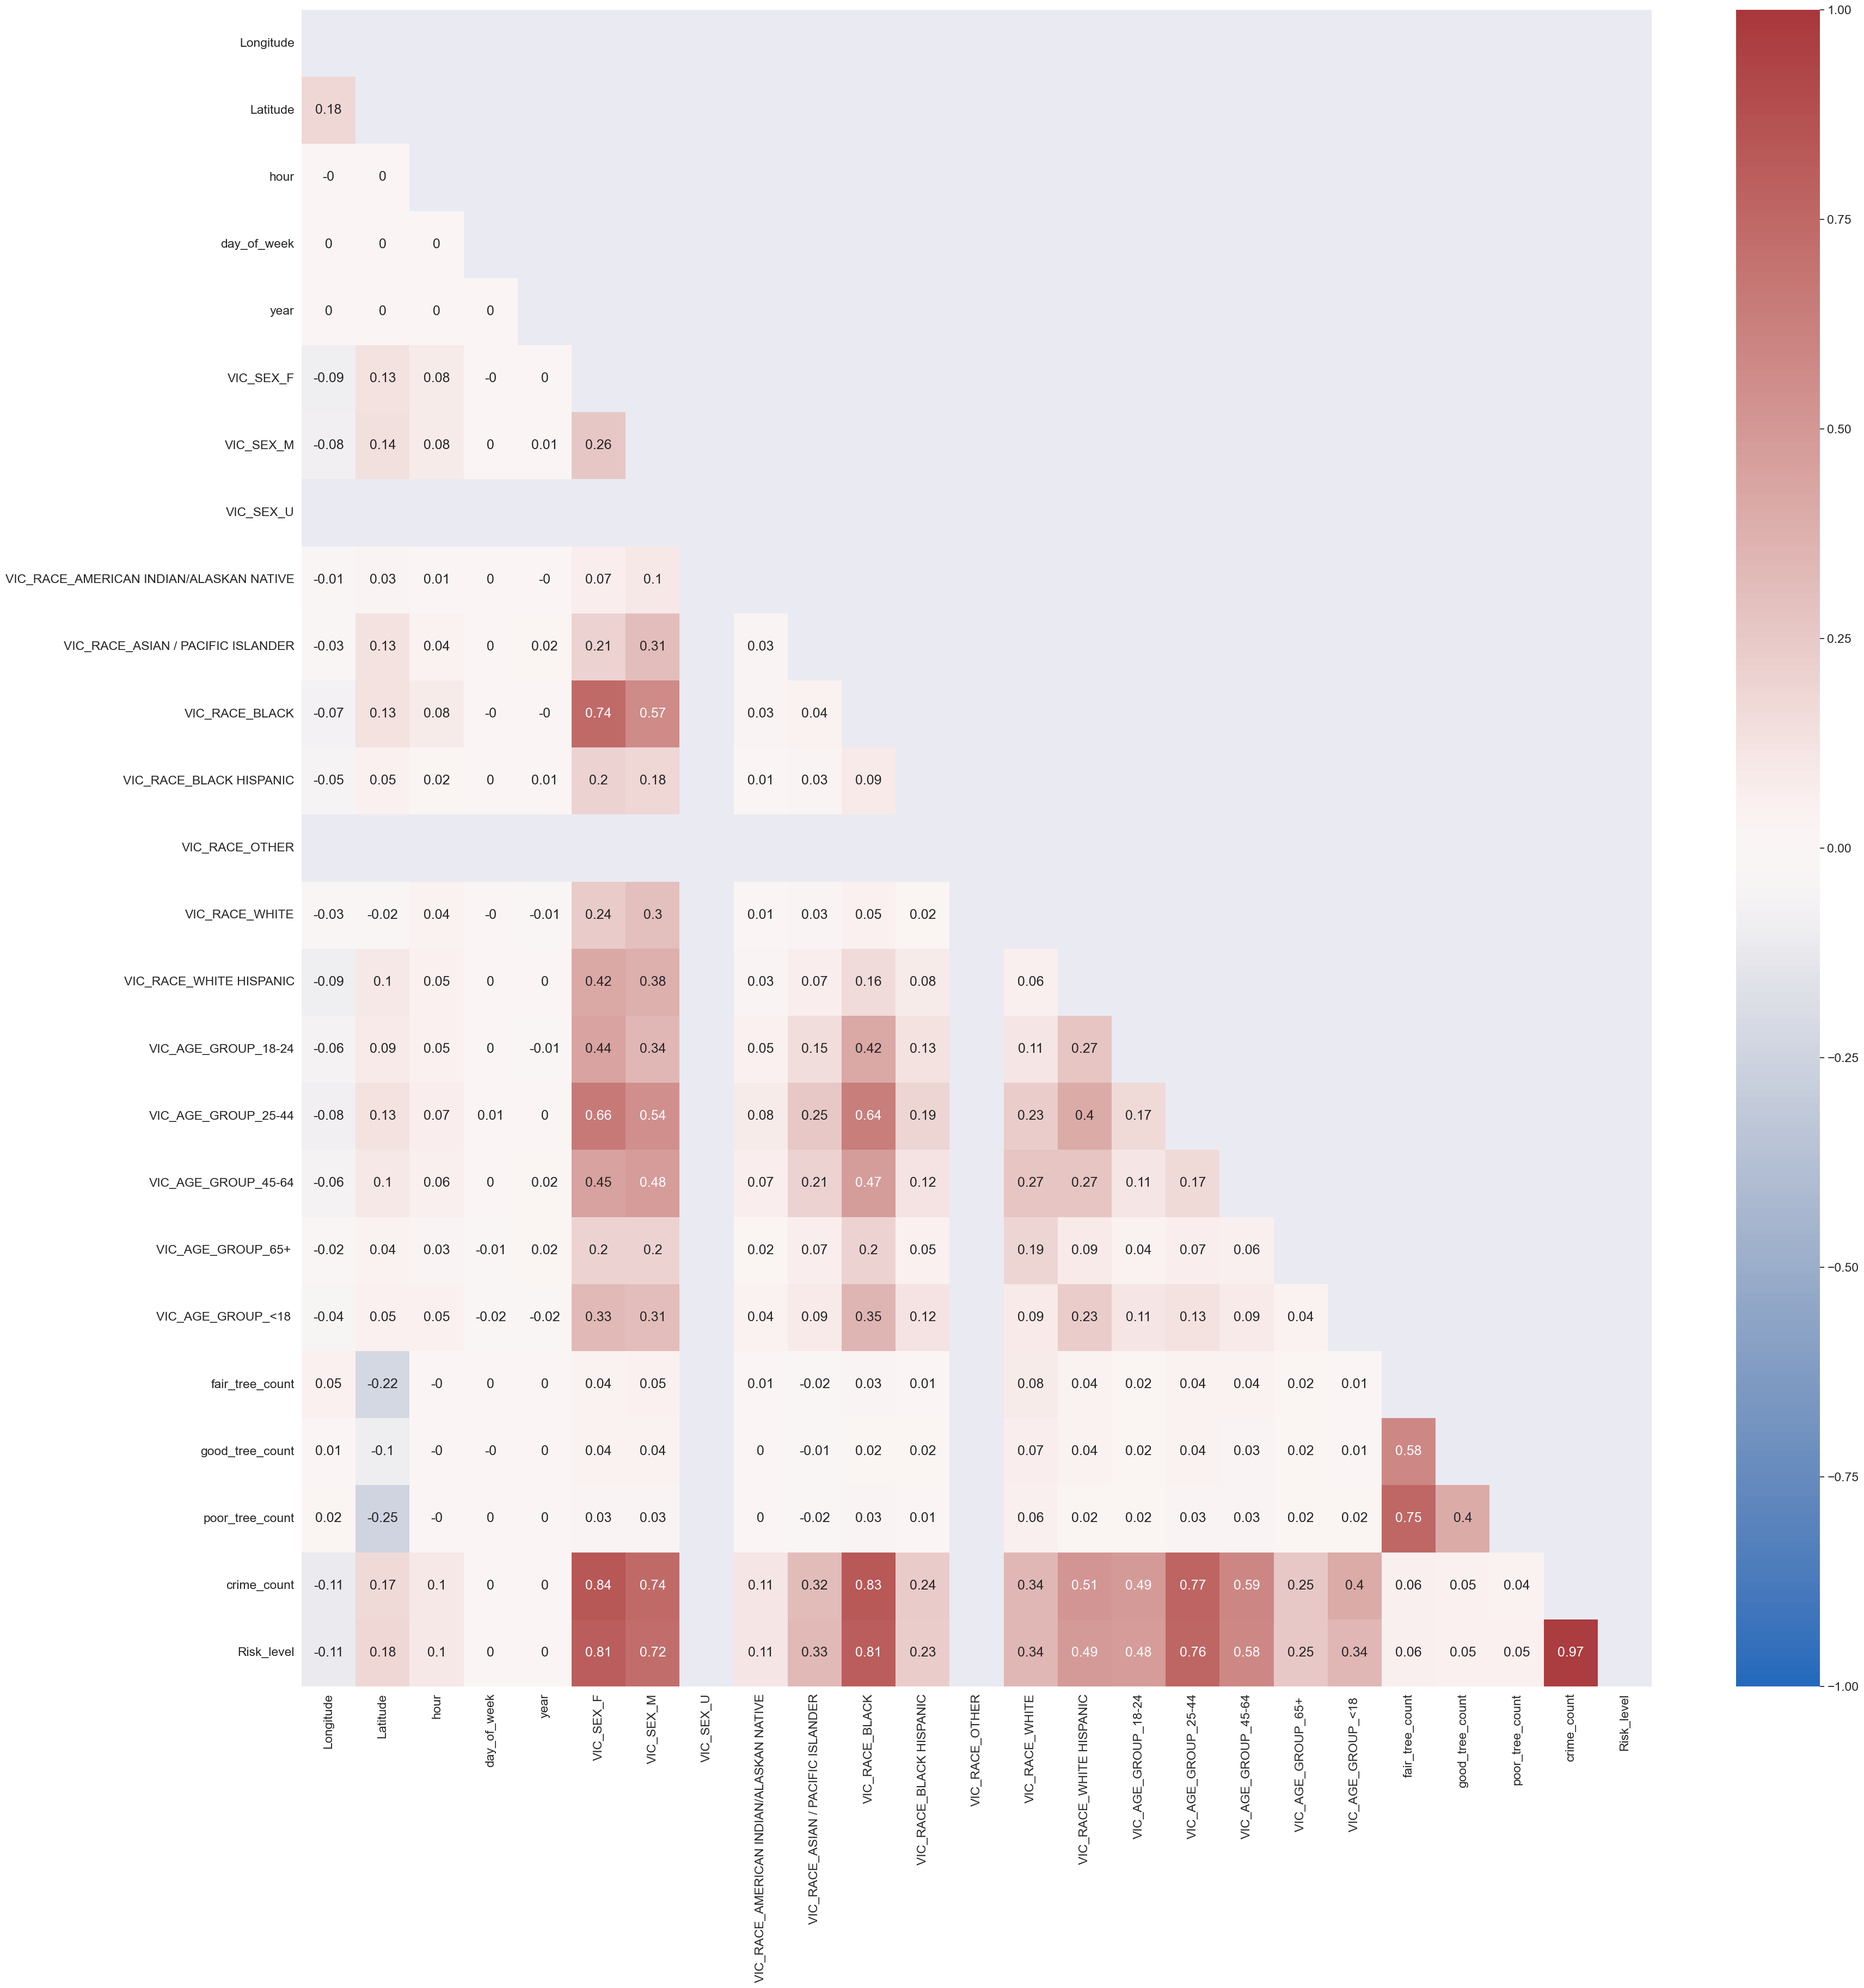

In [108]:
corr_matrix = matched_data.corr().round(2)
# print(corr_matrix)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(40,40))       
sns.heatmap(corr_matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask, ax=ax)
plt.show()

## Representation bias

In [109]:
merged_data2010 = matched_data.loc[matched_data['year'] == 2010]

In [110]:
merged_data2010

,Longitude,Latitude,hour,day_of_week,year,VIC_SEX_F,VIC_SEX_M,VIC_SEX_U,VIC_RACE_AMERICAN INDIAN/ALASKAN NATIVE,VIC_RACE_ASIAN / PACIFIC ISLANDER,...,VIC_AGE_GROUP_18-24,VIC_AGE_GROUP_25-44,VIC_AGE_GROUP_45-64,VIC_AGE_GROUP_65+,VIC_AGE_GROUP_<18,fair_tree_count,good_tree_count,poor_tree_count,crime_count,Risk_level
4,-73.90204,40.55968,0.0,0.0,2010.0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,1.0,0,0
19,-73.90204,40.55968,0.0,1.0,2010.0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,1.0,0,0
34,-73.90204,40.55968,0.0,2.0,2010.0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,1.0,0,0
49,-73.90204,40.55968,0.0,3.0,2010.0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,1.0,0,0
64,-73.90204,40.55968,0.0,4.0,2010.0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282609,-73.72807,40.68253,23.0,2.0,2010.0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0,0
1282624,-73.72807,40.68253,23.0,3.0,2010.0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0,0
1282639,-73.72807,40.68253,23.0,4.0,2010.0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0,0
1282654,-73.72807,40.68253,23.0,5.0,2010.0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0,0


In [154]:
merged_data2010['VIC_SEX_F'].sum()

14475

In [111]:
total_male = merged_data2010['VIC_SEX_M'].sum()
total_female = merged_data2010['VIC_SEX_F'].sum()


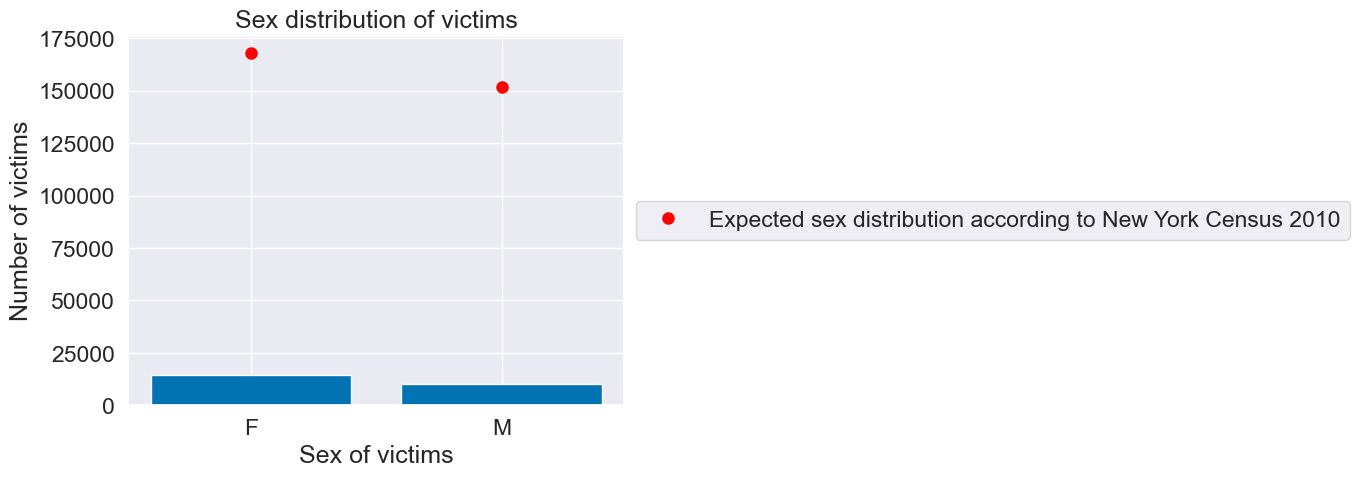

In [112]:
x = ['F', 'M']  # categories
y = [total_female, total_male]  # values
bin_edges = range(len(x) + 1)  # define bin edges

plt.bar(x, y)
plt.xticks(range(len(x)), x)
plt.xlabel('Sex of victims')
plt.ylabel('Number of victims')
plt.title('Sex distribution of victims')
plt.plot(range(len(x)), [167849, 151816], 'o--', c='red', linewidth=0, markersize=8, label='Expected sex distribution according to New York Census 2010')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [113]:
total_18 = merged_data2010.iloc[:, 17].sum()
total_24 = merged_data2010['VIC_AGE_GROUP_18-24'].sum()
total_44 = merged_data2010['VIC_AGE_GROUP_25-44'].sum()
total_64 = merged_data2010['VIC_AGE_GROUP_45-64'].sum()
total_65 = merged_data2010.iloc[:, 16].sum()

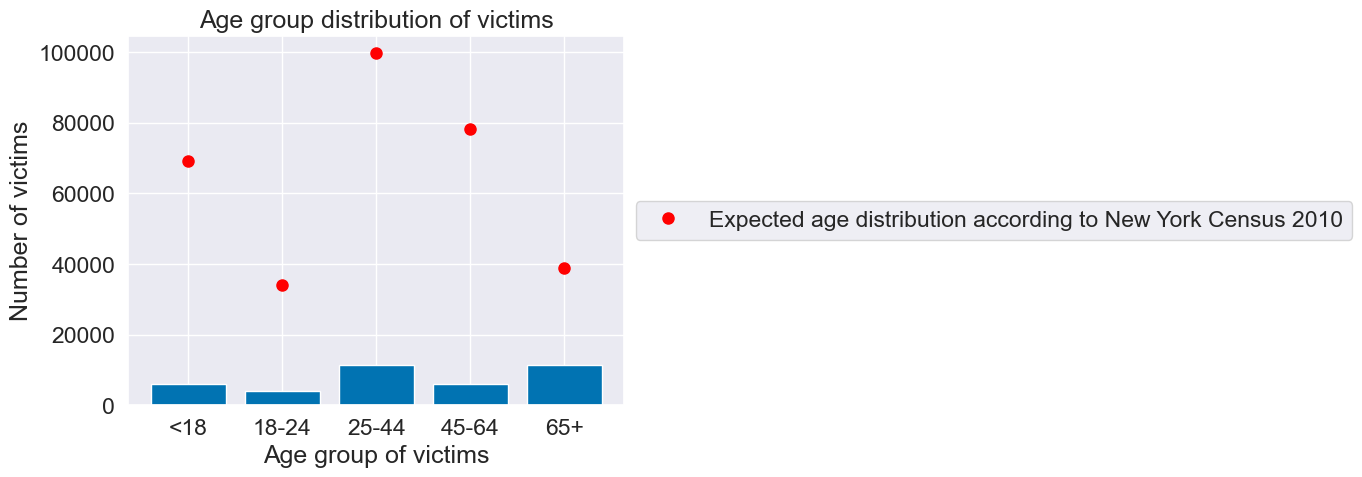

In [114]:
x = ['<18', '18-24', '25-44', '45-64', '65+']
y = [total_18, total_24, total_44, total_64, total_65]

bin_edges = np.arange(len(x) + 1) - 0.5  # add a half bin width to shift the edges to the center of the bars
bin_edges = range(len(x) + 1)  # define bin edges

plt.bar(x, y)
plt.xticks(range(len(x)), x)
plt.xlabel('Age group of victims')
plt.ylabel('Number of victims')
plt.title('Age group distribution of victims')
plt.plot(range(len(x)), [69137, 33993, 99598, 78102, 38835], 'o--', c='red', linewidth=0, markersize=8, label='Expected age distribution according to New York Census 2010')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [115]:
white_hispanic = merged_data2010['VIC_RACE_WHITE HISPANIC'].sum()
black = merged_data2010['VIC_RACE_BLACK'].sum()
white = merged_data2010['VIC_RACE_WHITE'].sum()
black_hispanic = merged_data2010['VIC_RACE_BLACK HISPANIC'].sum()
asian_pacific = merged_data2010['VIC_RACE_ASIAN / PACIFIC ISLANDER'].sum()
american_alaskan = merged_data2010['VIC_RACE_AMERICAN INDIAN/ALASKAN NATIVE'].sum()
other = merged_data2010['VIC_RACE_OTHER'].sum()

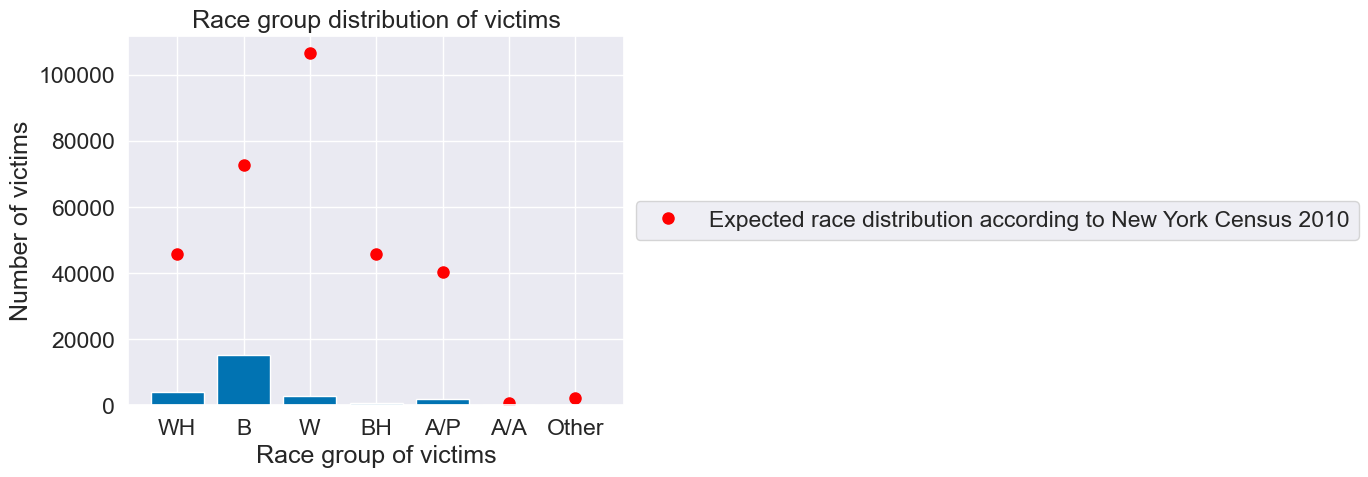

In [116]:
x = ['WH','B','W','BH','A/P','A/A', 'Other']
y = [white_hispanic, black, white, black_hispanic, asian_pacific, american_alaskan, other]

bin_edges = np.arange(len(x) + 1) - 0.5  # add a half bin width to shift the edges to the center of the bars
bin_edges = range(len(x) + 1)  # define bin edges

plt.bar(x, y)
plt.xticks(range(len(x)), x)
plt.xlabel('Race group of victims')
plt.ylabel('Number of victims')
plt.title('Race group distribution of victims')
plt.plot(range(len(x)), [45673 , 72781, 106471, 45673, 40311, 681 ,2262], 'o--', c='red', linewidth=0, markersize=8, label='Expected race distribution according to New York Census 2010')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Historical bias

In [117]:
non_victim_male = 3882544 - merged_data2010['VIC_SEX_M'].sum()
non_victim_female = 4292589 - merged_data2010['VIC_SEX_F'].sum()

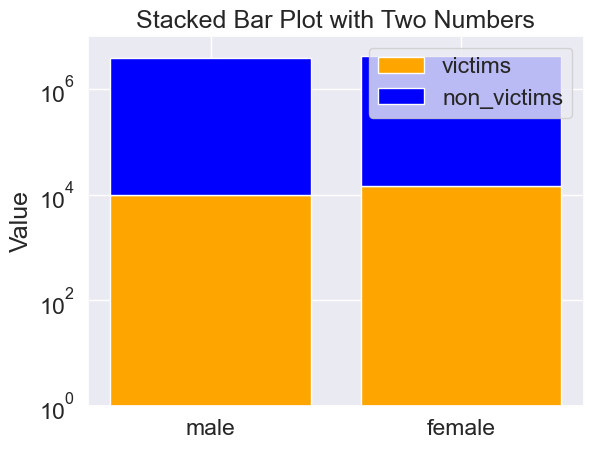

In [118]:
import matplotlib.ticker as ticker

# Define the data and log scale it
victims = [total_male, total_female]
non_victims = [non_victim_male, non_victim_female]

labels = ['male', 'female']
colors = ['orange', 'blue']

# Create the stacked bar plot
x = np.arange(len(labels))
plt.bar(x, victims, color=colors[0], label='victims')
plt.bar(x, non_victims, bottom=victims, color=colors[1], label='non_victims')
plt.xticks(x, labels)
plt.ylabel('Value')
plt.title('Stacked Bar Plot with Two Numbers')
plt.legend()

# Set y-axis to log scale and adjust limits
plt.yscale('log')
plt.ylim([1, 10**7])

# Set y-axis tick labels to display original scale values

# Show the plot
plt.show()

In [119]:
non_victim_male

3872542

In [120]:
non_victim_18 = 1768111 - merged_data2010.iloc[:, 17].sum()
non_victim_24 = merged_data2010['VIC_AGE_GROUP_18-24'].sum()
non_victim_44 = merged_data2010['VIC_AGE_GROUP_25-44'].sum()
non_victim_64 = merged_data2010['VIC_AGE_GROUP_45-64'].sum()
non_victim_65 = merged_data2010.iloc[:, 16].sum()

# Predictive Analytics

In [177]:
trees_crimes_people_df = matched_data

,Longitude,Latitude,hour,day_of_week,year,VIC_SEX_F,VIC_SEX_M,VIC_SEX_U,VIC_RACE_AMERICAN INDIAN/ALASKAN NATIVE,VIC_RACE_ASIAN / PACIFIC ISLANDER,...,VIC_AGE_GROUP_18-24,VIC_AGE_GROUP_25-44,VIC_AGE_GROUP_45-64,VIC_AGE_GROUP_65+,VIC_AGE_GROUP_<18,fair_tree_count,good_tree_count,poor_tree_count,crime_count,Risk_level
0,-73.90204,40.55968,0.0,0.0,2006.0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,1.0,0,0
1,-73.90204,40.55968,0.0,0.0,2007.0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,1.0,0,0
2,-73.90204,40.55968,0.0,0.0,2008.0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,1.0,0,0
3,-73.90204,40.55968,0.0,0.0,2009.0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,1.0,0,0
4,-73.90204,40.55968,0.0,0.0,2010.0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282675,-73.72807,40.68253,23.0,6.0,2016.0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0,0
1282676,-73.72807,40.68253,23.0,6.0,2017.0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0,0
1282677,-73.72807,40.68253,23.0,6.0,2018.0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0,0
1282678,-73.72807,40.68253,23.0,6.0,2019.0,0,1,0,0,0,...,0,1,0,0,0,0.0,0.0,0.0,3,1


In [179]:
trees_crimes_people_df.columns

Index(['Longitude', 'Latitude', 'hour', 'day_of_week', 'year', 'VIC_SEX_F',
       'VIC_SEX_M', 'VIC_SEX_U', 'VIC_RACE_AMERICAN INDIAN/ALASKAN NATIVE',
       'VIC_RACE_ASIAN / PACIFIC ISLANDER', 'VIC_RACE_BLACK',
       'VIC_RACE_BLACK HISPANIC', 'VIC_RACE_OTHER', 'VIC_RACE_WHITE',
       'VIC_RACE_WHITE HISPANIC', 'VIC_AGE_GROUP_18-24', 'VIC_AGE_GROUP_25-44',
       'VIC_AGE_GROUP_45-64', 'VIC_AGE_GROUP_65+ ', 'VIC_AGE_GROUP_<18 ',
       'fair_tree_count', 'good_tree_count', 'poor_tree_count', 'crime_count',
       'Risk_level'],
      dtype='object')

In [187]:
X

,Longitude,Latitude,hour,day_of_week,fair_tree_count,good_tree_count,poor_tree_count
0,-73.90204,40.55968,0.0,0.0,0.0,0.0,1.0
1,-73.90204,40.55968,0.0,0.0,0.0,0.0,1.0
2,-73.90204,40.55968,0.0,0.0,0.0,0.0,1.0
3,-73.90204,40.55968,0.0,0.0,0.0,0.0,1.0
4,-73.90204,40.55968,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
1282675,-73.72807,40.68253,23.0,6.0,0.0,0.0,0.0
1282676,-73.72807,40.68253,23.0,6.0,0.0,0.0,0.0
1282677,-73.72807,40.68253,23.0,6.0,0.0,0.0,0.0
1282678,-73.72807,40.68253,23.0,6.0,0.0,0.0,0.0


In [186]:
# Slide the dataframe and move colums 4 and 5 to df Y. Keep the rest in df X
Y = trees_crimes_people_df.iloc[:, [24]]

X = trees_crimes_people_df.iloc[:, [0,1,2,3, 20,21,22]]

In [188]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)

## Baseline: Naive Bayes Classification

In [189]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

gnb = GaussianNB()
gnb.fit(X_train, Y_train)
Y_pred = gnb.predict(X_test)
print("Accuracy (Dropped categorical): ", accuracy_score(Y_test, Y_pred))
print("F1 (Dropped categorical): ", f1_score(Y_test, Y_pred, average='weighted'))

C:\Users\Kelvi\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy (Dropped categorical):  0.7773474288209062
F1 (Dropped categorical):  0.7174283512521047


## Initialise models for testing

In [190]:
from sklearn.linear_model import Perceptron, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# Convert Y_train and Y_test to 1D array
Y_train = Y_train.to_numpy().ravel()
Y_test = Y_test.to_numpy().ravel()

regressor_names = [
    "Lasso",
    "Elastic Net",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "K-Nearest Neighbours"
]

classifier_names = [
    "Logistic Regression",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Neural Net",
    "K-Nearest Neighbours"
]

regressors = [
    Lasso(alpha=0.1),
    ElasticNet(random_state=0),
    DecisionTreeRegressor(max_depth=5),
    RandomForestRegressor(max_depth=5, n_estimators=10, max_features=1),
    MLPRegressor(alpha=1, max_iter=1000),
    KNeighborsRegressor(3),
]

classifiers = [
    LogisticRegression(random_state=0),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    MLPClassifier(alpha=1, max_iter=1000),
    KNeighborsClassifier(3),
]

## Test different Classification models

In [191]:
categorical_technique_list = ["Just-One"]
X_train_list = [X_train]
X_test_list = [X_test]

accuracy_per_dataset_df = pandas.DataFrame(columns=["Dataset Name"].append(classifier_names))
balanced_accuracy_per_dataset_df = pandas.DataFrame(columns=["Dataset Name"].append(classifier_names))
f1_score_per_dataset_df = pandas.DataFrame(columns=["Dataset Name"].append(classifier_names))

for technique,X_train,X_test in zip(categorical_technique_list,X_train_list,X_test_list):
    print("[INFO] - Categorical technique: ", technique)
    accuracy_line = {"Dataset Name": technique}
    balanced_accuracy_line = {"Dataset Name": technique}
    f1_score_line = {"Dataset Name": technique}

    for classifier,method_name in zip(classifiers,classifier_names):
        print("[INFO] - Classifier: ", method_name)
        classifier.fit(X_train, Y_train)
        Y_pred = classifier.predict(X_test)
        accuracy_line[method_name] = accuracy_score(Y_test,Y_pred)
        balanced_accuracy_line[method_name] = balanced_accuracy_score(Y_test,Y_pred)
        f1_score_line[method_name] = f1_score(Y_test,Y_pred, average='weighted')

    accuracy_per_dataset_df = pandas.concat([accuracy_per_dataset_df, pandas.DataFrame(accuracy_line.values(), index=accuracy_line.keys()).T], ignore_index=True)
    balanced_accuracy_per_dataset_df = pandas.concat([balanced_accuracy_per_dataset_df, pandas.DataFrame(balanced_accuracy_line.values(), index=balanced_accuracy_line.keys()).T], ignore_index=True)
    f1_score_per_dataset_df = pandas.concat([f1_score_per_dataset_df, pandas.DataFrame(f1_score_line.values(), index=f1_score_line.keys()).T], ignore_index=True)

[INFO] - Categorical technique:  Just-One
[INFO] - Classifier:  Logistic Regression


C:\Users\Kelvi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[INFO] - Classifier:  Decision Tree
[INFO] - Classifier:  Random Forest
[INFO] - Classifier:  AdaBoost
[INFO] - Classifier:  Neural Net
[INFO] - Classifier:  K-Nearest Neighbours


C:\Users\Kelvi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [192]:
# unpivot the dataframe
accuracy_per_dataset_df = accuracy_per_dataset_df.melt(id_vars=['Dataset Name'], var_name='Method', value_name='Accuracy')
accuracy_per_dataset_df

,Dataset Name,Method,Accuracy
0,Just-One,Logistic Regression,0.805738
1,Just-One,Decision Tree,0.806652
2,Just-One,Random Forest,0.805747
3,Just-One,AdaBoost,0.803929
4,Just-One,Neural Net,0.805747
5,Just-One,K-Nearest Neighbours,0.783142


In [193]:
# unpivot the dataframe
balanced_accuracy_per_dataset_df = balanced_accuracy_per_dataset_df.melt(id_vars=['Dataset Name'], var_name='Method', value_name='Balanced Accuracy')
balanced_accuracy_per_dataset_df

,Dataset Name,Method,Balanced Accuracy
0,Just-One,Logistic Regression,0.250037
1,Just-One,Decision Tree,0.268357
2,Just-One,Random Forest,0.25
3,Just-One,AdaBoost,0.259164
4,Just-One,Neural Net,0.25
5,Just-One,K-Nearest Neighbours,0.338063


In [194]:
# unpivot the dataframe
f1_score_per_dataset_df = f1_score_per_dataset_df.melt(id_vars=['Dataset Name'], var_name='Method', value_name='F1 Score')
f1_score_per_dataset_df

,Dataset Name,Method,F1 Score
0,Just-One,Logistic Regression,0.719125
1,Just-One,Decision Tree,0.741961
2,Just-One,Random Forest,0.719069
3,Just-One,AdaBoost,0.730373
4,Just-One,Neural Net,0.719069
5,Just-One,K-Nearest Neighbours,0.755677


# Lab 6


In [195]:
KNeighborsClassifier(3).fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)

C:\Users\Kelvi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [196]:
X_test

,Longitude,Latitude,hour,day_of_week,fair_tree_count,good_tree_count,poor_tree_count
1207464,-73.74490,40.66982,3.0,4.0,0.0,0.0,0.0
72274,-73.89643,40.59781,16.0,2.0,0.0,0.0,0.0
1140161,-73.75052,40.59781,10.0,4.0,1.0,0.0,0.0
1004795,-73.76735,40.59781,17.0,3.0,1.0,2.0,2.0
297626,-73.87398,40.65712,2.0,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1037303,-73.76735,40.66135,15.0,0.0,0.0,0.0,0.0
688735,-73.81225,40.65288,7.0,2.0,0.0,0.0,0.0
775383,-73.80102,40.67406,16.0,4.0,0.0,0.0,0.0
882192,-73.78419,40.63170,1.0,5.0,0.0,0.0,0.0


In [197]:
prediction = X_test

In [198]:
prediction['real_risk'] = Y_test

In [199]:
prediction['predicted_risk'] = Y_pred

In [200]:
prediction

,Longitude,Latitude,hour,day_of_week,fair_tree_count,good_tree_count,poor_tree_count,real_risk,predicted_risk
1207464,-73.74490,40.66982,3.0,4.0,0.0,0.0,0.0,2,0
72274,-73.89643,40.59781,16.0,2.0,0.0,0.0,0.0,0,0
1140161,-73.75052,40.59781,10.0,4.0,1.0,0.0,0.0,1,0
1004795,-73.76735,40.59781,17.0,3.0,1.0,2.0,2.0,0,0
297626,-73.87398,40.65712,2.0,3.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...
1037303,-73.76735,40.66135,15.0,0.0,0.0,0.0,0.0,1,0
688735,-73.81225,40.65288,7.0,2.0,0.0,0.0,0.0,0,0
775383,-73.80102,40.67406,16.0,4.0,0.0,0.0,0.0,1,0
882192,-73.78419,40.63170,1.0,5.0,0.0,0.0,0.0,0,0


In [202]:
prediction['predicted_risk'].value_counts()

0    283413
1     28859
2      5006
3      3392
Name: predicted_risk, dtype: int64

In [ ]:
prediction['VIC_AGE_GROUP'] == df[['dummy1', 'dummy2']].apply(lambda x: x.idxmax(), axis=1)

In [153]:
prediction.iloc[:,5].min()

0

In [158]:
df = pandas.DataFrame({'dummy1': [1, 0, 1], 'dummy2': [0, 1, 1], 'dummy3': [1, 1, 0]})

# use apply to find the column with the highest value (i.e., 1) in each row, for dummy1 and dummy2 only
df['combined'] = df[['dummy1', 'dummy2']].apply(lambda x: x.idxmax(), axis=1)

# display the updated DataFrame
print(df)

   dummy1  dummy2  dummy3 combined
0       1       0       1   dummy1
1       0       1       1   dummy2
2       1       1       0   dummy1


In [149]:
group = Group()
xtab, _ = group.get_crosstabs(prediction)

Exception: get_crosstabs: input df was not preprocessed. There are non-string cols within attr_cols!

## Test different Regression models

In [132]:
categorical_technique_list = ["Just one"]
X_train_list = [X_train]
X_test_list = [X_test]

# Create a dictionary to store the dataframes of the results for each method
results_dict = {}

MSE_per_dataset_df = pd.DataFrame(columns=["Dataset Name"].append(names))
MAE_per_dataset_df = pd.DataFrame(columns=["Dataset Name"].append(names))
MAPE_per_dataset_df = pd.DataFrame(columns=["Dataset Name"].append(names))

for technique,X_train,X_test in zip(categorical_technique_list,X_train_list,X_test_list):
    print("[INFO] - Categorical technique: ", technique)
    MSE_line = {"Dataset Name": technique}
    MAE_line = {"Dataset Name": technique}
    MAPE_line = {"Dataset Name": technique}

    for regressor,method_name in zip(regressors,regressor_names):
        print("[INFO] - Regressor: ", method_name)
        regressor.fit(X_train, Y_train)
        Y_pred = regressor.predict(X_test)
        # create a dataframe with the Y_test and Y_pred
        Y_test_Y_pred_df = pd.DataFrame({'Y_test': Y_test, 'Y_pred': Y_pred})
        # append the dataframe to the dictionary
        results_dict[method_name] = Y_test_Y_pred_df
        # calculate the MSE, MAE and MAPE
        MSE_line[method_name] = mean_squared_error(Y_test, Y_pred)
        MAE_line[method_name] = mean_absolute_error(Y_test, Y_pred)
        MAPE_line[method_name] = mean_absolute_percentage_error(Y_test, Y_pred)


    # using pandas concat to append the new line to the dataframe
    MSE_per_dataset_df = pandas.concat([MSE_per_dataset_df, pd.DataFrame([MSE_line])], ignore_index=True)
    MAE_per_dataset_df = pandas.concat([MAE_per_dataset_df, pd.DataFrame([MAE_line])], ignore_index=True)
    MAPE_per_dataset_df = pandas.concat([MAPE_per_dataset_df, pd.DataFrame([MAPE_line])], ignore_index=True)


NameError: name 'pd' is not defined

In [ ]:
# unpivot the dataframe
MSE_per_dataset_df = MSE_per_dataset_df.melt(id_vars=['Dataset Name'], var_name='Method', value_name='MSE')
MSE_per_dataset_df

In [ ]:
MAE_per_dataset_df = MAE_per_dataset_df.melt(id_vars=['Dataset Name'], var_name='Method', value_name='MAE')
MAE_per_dataset_df

In [ ]:
MAPE_per_dataset_df

## Intrinsic Explainability

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

# define the model
model = KNeighborsRegressor(3)

# fit the model
model.fit(X_train, Y_train)

# perform permutation importance
results = permutation_importance(model, X_test, Y_test, scoring='neg_mean_squared_error')

# get importance
importance = results.importances_mean